## Process 3P Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
plt.rcParams.update({'font.size': 16})

### 1. Read and load data from file

First, read the `csv` data file containing the neutron star (NS) equations of states (EoS) and their mass-radius ($M-R$) curves. Look at the first few rows of all columns. 

In [2]:
df = pd.read_csv("threep.csv", low_memory=False)
df.head()

,P_0,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,...,R_90,R_91,R_92,R_93,R_94,R_95,R_96,R_97,R_98,R_99
0,[1/fm^4],[1/fm^4],[1/fm^4],[1/fm^4],[1/fm^4],[1/fm^4],[1/fm^4],[1/fm^4],[1/fm^4],[1/fm^4],...,[km],[km],[km],[km],[km],[km],[km],[km],[km],[km]
1,0.0012938,0.00222522,0.00361156,0.00560412,0.00835703,0.01202504,0.0167625,0.02272262,0.03005639,0.03891129,...,0,0,0,0,0,0,0,0,0,0
2,0.00134091,0.00233449,0.00382714,0.0059881,0.00899091,0.01301017,0.01821953,0.02479012,0.0328887,0.04267561,...,0,0,0,0,0,0,0,0,0,0
3,0.00124211,0.00216685,0.0036,0.00573826,0.00879095,0.01297624,0.01851781,0.02564095,0.03456766,0.04551092,...,0,0,0,0,0,0,0,0,0,0
4,0.00133913,0.00237178,0.00392165,0.00614433,0.00919613,0.01323152,0.01840111,0.02484974,0.03271444,0.04212224,...,0,0,0,0,0,0,0,0,0,0


The columns $P_0 \cdots P_{99}$ are pressures $P$ as functions of energy densities $\epsilon$. Each row of $\mathbf{P}$ corresponds to an EoS: $P = P(\epsilon)$. On the other hand, the columns $R_0 \cdots R_{99}$ is radius $R$ as a function of NS mass $M$. Each row of $\mathbf{R}$ represents an $M-R$ curve.

Load the pressure and the radius matrices and check their dimensions.

In [3]:
p = df.iloc[1:, 0:100]
r = df.iloc[1:, 100:200]

p = np.array(p, dtype=float)
r = np.array(r, dtype=float)

print("dim(R) =", r.shape[0], "x", r.shape[1])
print("dim(P) =", p.shape[0], "x", p.shape[1])

dim(R) = 24232 x 100
dim(P) = 24232 x 100


### 2. Convert units and visualize data

The pressure (and energy density) has unit $1/\mathrm{fm}^4$. In the natural unit system $\hbar=c=1$, we use $\hbar c = 1 = 197.327 \; \mathrm{MeV.fm}$ and convert to $\mathrm{MeV/fm^3}$. However, we leave the radius alone which has unit $\mathrm{km}$.

This choice of units doesn't matter while using 3P or 4L data only since both quantities (pressure and radius) are eventually normalized. However, if we use mixed data set (e.g., 3P-4L or 3P-4L-tidal), their units must match before the data sets are combined and normalized.

In [4]:
ħc = 197.327 # MeV.fm

Pr = np.zeros_like(p)
Rd = r

for i in range(p.shape[0]):
    Pr[i] = p[i] * ħc

Plot some randomly chosen rows of $\mathbf{R}$ (the $M-R$ curves) and $\mathbf{P}$ (the EoS or $P-\epsilon$ curves).

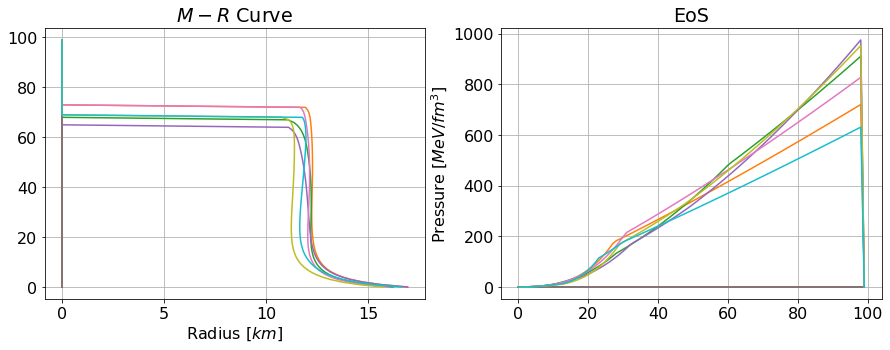

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].set_xlabel("Radius [$km$]")
ax[0].set_title("$M-R$ Curve")
ax[0].grid()
ax[1].set_ylabel("Pressure [$MeV / fm^3$]")
ax[1].set_title("EoS")
ax[1].grid()

z = np.arange(100)

for j in range(10):
    i = np.random.choice(Rd.shape[0])
    x = Rd[i]
    y = Pr[i]
    ax[0].plot(x,z)
    ax[1].plot(y)

### 3. Cut off zero columns

Note that the last (99$^{th}$) columns of $\mathbf{R}$ and $\mathbf{P}$ are zeros. We use the data up to column 98 of these matrices and check their dimensions.

In [6]:
rd = Rd[:,:99]
pr = Pr[:,:99]

print("dim(R) =", rd.shape[0], "x", rd.shape[1])
print("dim(P) =", pr.shape[0], "x", pr.shape[1])

dim(R) = 24232 x 99
dim(P) = 24232 x 99


Plot some random data for visualization.

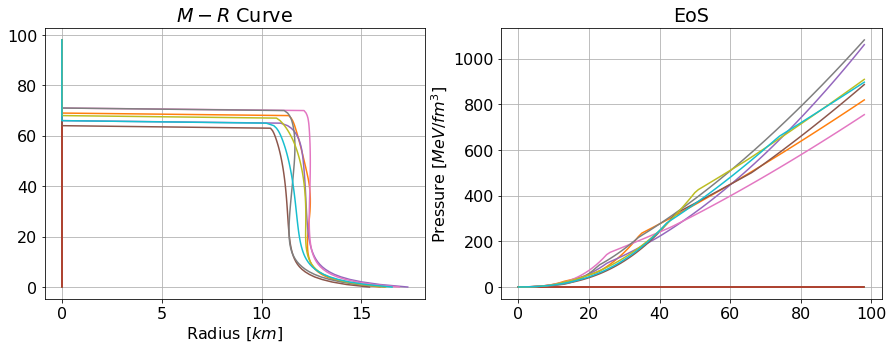

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].set_xlabel("Radius [$km$]")
ax[0].set_title("$M-R$ Curve")
ax[0].grid()
ax[1].set_ylabel("Pressure [$MeV / fm^3$]")
ax[1].set_title("EoS")
ax[1].grid()

z = np.arange(99)

for j in range(10):
    i = np.random.choice(rd.shape[0])
    x = rd[i]
    y = pr[i]
    ax[0].plot(x,z)
    ax[1].plot(y)

### 4. Remove zero rows

Upon randomly plotting the above data a few times, we notice that some rows in $\mathbf{R}$ and $\mathbf{P}$ are zeros. The vertical line(s) on the $M-R$ plot and the horizontal line(s) on the EoS plot suggest so. We exclude these zero rows and check the dimensions of the matrices again.

In [8]:
R, P = [], []

for i in range(rd.shape[0]):
    ri = rd[i]
    pi = pr[i]
    if (pi.all()!=0):
        P.append(pi)
        R.append(ri)

P = np.array(P)
R = np.array(R)

print("dim(R) =", R.shape[0], "x", R.shape[1])
print("dim(P) =", P.shape[0], "x", P.shape[1])

dim(R) = 10843 x 99
dim(P) = 10843 x 99


Plot the remaining data to verify if the vertical and the horizontal lines have vanished.

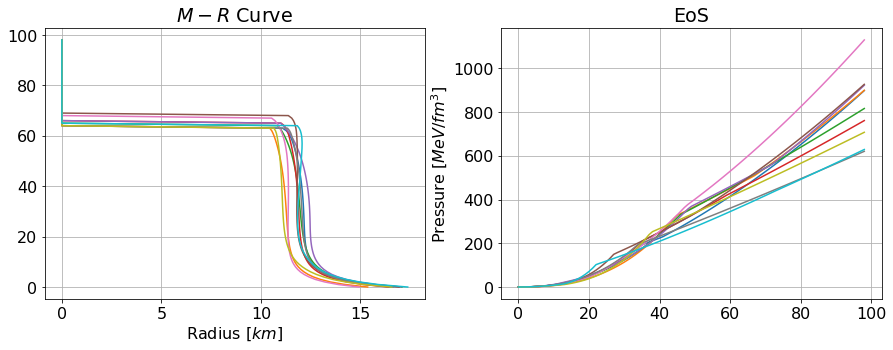

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].set_xlabel("Radius [$km$]")
ax[0].set_title("$M-R$ Curve")
ax[0].grid()
ax[1].set_ylabel("Pressure [$MeV / fm^3$]")
ax[1].set_title("EoS")
ax[1].grid()

z = np.arange(99)

for j in range(10):
    i = np.random.choice(R.shape[0])
    x = R[i]
    y = P[i]
    ax[0].plot(x,z)
    ax[1].plot(y)

### 5. Recover cut off columns by extrapolation

Here, we extrapolate points and recover the cut off column(s). For the EoS, we find the last point(s) by a linear (spline) extrapolation. As for the $M-R$ curves, we only fill the last column(s) with zeros since the previous few columns also have zeros.

In [10]:
# Define a function to extrapolate EoS and replace negative pressures with zeros
def extrapolate_eos(y):
    x100 = np.arange(100)
    x99 = np.arange(99)
    f_eos = interpolate.interp1d(x99, y, kind='slinear', bounds_error=False, fill_value='extrapolate')
    eos = f_eos(x100)
    for i in range(len(eos)):
        if eos[i] < 0.0:
            eos[i] = 0.0
    return eos

# Define a function to fill the last column(s) of the M-R curves with zeros
def extrapolate_mrc(x):
    mrc = np.zeros(100)
    mrc[:99] = x
    mrc[-1] = 0.0
    return mrc

In [11]:
# Perform the extrapolations and construct new EoS and M-R curves
eos, mrc = [], []

for i in range(R.shape[0]):
    eos.append(extrapolate_eos(P[i]))
    mrc.append(extrapolate_mrc(R[i]))

eos = np.array(eos)
mrc = np.array(mrc)

print("dim(R) =", mrc.shape[0], "x", mrc.shape[1])
print("dim(P) =", eos.shape[0], "x", eos.shape[1])

dim(R) = 10843 x 100
dim(P) = 10843 x 100


Plot some random data to verify that the last column(s) are filled with extrapolated points.

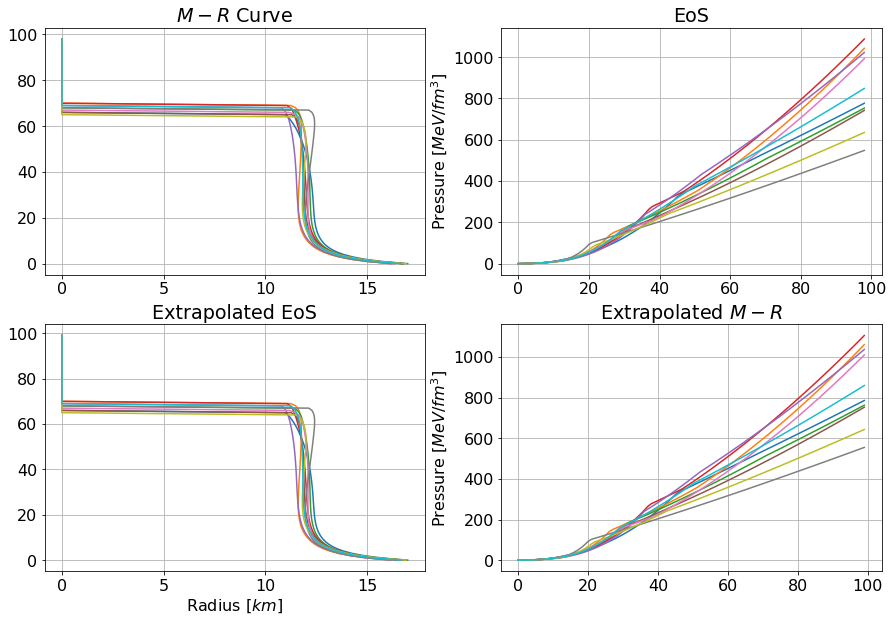

In [12]:
x100 = np.arange(100)
x99 = np.arange(99)

fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[1,0].set_xlabel("Radius [$km$]")
ax[0,1].set_ylabel("Pressure [$MeV / fm^3$]")
ax[1,1].set_ylabel("Pressure [$MeV / fm^3$]")
ax[0,0].set_title("$M-R$ Curve")
ax[0,1].set_title("EoS")
ax[1,0].set_title("Extrapolated EoS")
ax[1,1].set_title("Extrapolated $M-R$")
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

for j in range(10):
    i = np.random.choice(R.shape[0])
    ax[0,0].plot(R[i], x99)
    ax[0,1].plot(P[i])
    ax[1,0].plot(mrc[i], x100)
    ax[1,1].plot(eos[i])

### 6. Write the processed data to files

Finally, the data is ready to be used for training neural networks. We save the radius and the pressure matrices in two separate text files.

In [13]:
# Save processed data as text files in this directory
np.savetxt("mrc_3p.txt", mrc)
np.savetxt("eos_3p.txt", eos)